# Discrete Bayes Filter

Start with a thought experiment. Assume a dog friendly workspace and so bring the dogs to work. The dogs wander out of your office into the halls and we need to track the dog. Somebody created a sonar sensor to attach to the dog and based on how quickly an echo comes back from the sensor as it emits a signal, we can tell whether the dog is in front of an open doorway or not. It also senses when the dog walks and reports direction where the dog has moved. 

If we start listening to the sensor, we might read 'door', 'hall', 'hall', and so on but how determine the exact location of where the dog is?

Assuming that there are only 10 positions in a single hallway, with consecutive numbers to the right of the previous number. If we move from position 9, as we start from 0, we go back to the position 0.

In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pos = np.array([0.1, 0.1, 0.1, 0.1, 0.1,
                0.1, 0.1, 0.1, 0.1, 0.1])

The above is the belief of the dog's position at any given time. Lets create a map of the hallway in another list. The number $1$ denotes a door and $0$ denotes a wall.

In [3]:
hallway = np.array([1, 1, 0, 0, 0,
                    0, 0, 0, 1, 0])

Assuming we start listening to the device, the data says 'door', which one is it? The probability associated with the doors in the hallway are now changed as the position is now at 'door'. 

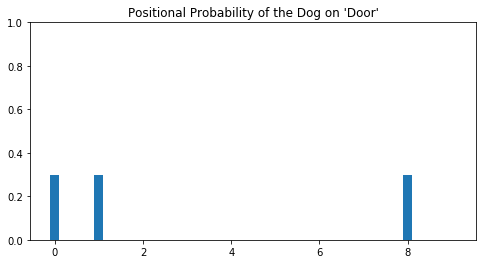

In [23]:
belief = hallway * 0.3
plt.figure(figsize=(8, 4))
plt.title("Positional Probability of the Dog on 'Door'")
plt.bar(x=range(hallway.shape[0]), height=belief, width=0.2)
plt.ylim((0, 1))
plt.show()

The above distribution is a multimodal distribution describing multiple beliefs of the position indicating that our knowledge now knows that the dog is at one of these locations. The benefit of the above thought experiment is that if we knew that the series of values were `door`, `right`, `door`, then it becomes trivial to know that the actual position of the dog is in front of the second door. Therefore, with more information from the sensor, it becomes easier to understand and correctly narrow down the possibilities with regards to the position of the dog and therefore end up with higher certainty than before. However, in real-life, the data from the sensors are extremely noisy and therefore requires further review.

## Noisy Sensors

The previous probability estimate creates the probabilities associated with the location of the dog. Now, the idea is to incorporate the additional uncertainty caused by the sensor noise. This is to say that there is a 50% chance that the dog is in front of a specific door when we get the reading 'door'.

In [32]:
def normalize(p):
    s = sum(p)
    # divide each element by the sum of all elements
    for i in range(len(p)):
        p[i] = p[i] / s
# --
def update(pos, measure, p_hit, p_miss):
    q = np.array(pos, dtype=float)
    for i in range(len(hallway)):
        if hallway[i] == measure:
            q[i] = pos[i] * p_hit
        else:
            q[i] = pos[i] * p_miss
    normalize(q)
    return q
# --
pos = np.array([0.2]*10)
reading = 1 #1 is 'door'
pos = update(pos, 1, 0.6, 0.2)
print(pos)

[0.1875 0.1875 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.1875 0.0625]


The above is the probabilties associated with the position now that we have a random probability that the sensor hits the accurate value or does not hit the accurate value at 0.6 and 0.2 respectively. The data requires normalization as the values when summed up to be 1.0 as in case of probabilities. The new probability estimates help us achieve two things:

1. Make the probability of wall and door to be actually probable. Wall is no longer at 0 probability.
2. This data now fits the intuition that there is a possibility of door being higher than the walls since there are fewer doors.

Probability of Door: 0.1875
Probability of Wall: 0.0625


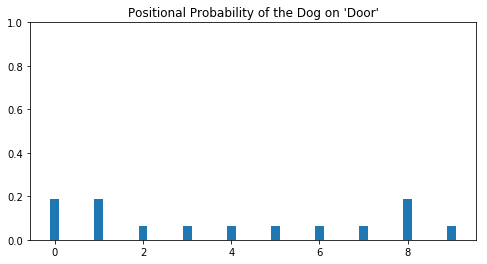

In [31]:
plt.figure(figsize=(8, 4))
print("Probability of Door: %.4f" % (pos[0]))
print("Probability of Wall: %.4f" % (pos[2]))
plt.title("Positional Probability of the Dog on 'Door'")
plt.bar(x=range(hallway.shape[0]), height=pos, width=0.2)
plt.ylim((0, 1))
plt.show()

## Incorporating Movement Data

The next question is whether an exact solution is possible in presence of noisy sensors? The answers obtained will never be 100% sure even though there will be a lot of complicated data.

Assuming the sensor is perfect, and reports that the dog has moved one space to the right, what is the alteration to the position array?

If we thought there was a 50% chance the dog was at position 3 and after moving there is a 50% chance that the dog was at position 4. This implementation will require the modulo arithmetic to perform.


In [38]:
def perfect_prediction(pos, move):
    """move the position by number of `move` spaces and is positive for right
    and negative for left"""
    n = len(pos)
    result = np.array(pos, dtype=float)
    for i in range(n):
        result[i] = pos[(i-move) % n]
    return result
# --
pos = np.array([0.4, 0.1, 0.2, 0.3])
print("Pos before Prediction: ", pos)

pos = perfect_prediction(pos, 1)
print("Pos after Prediction: ", pos)

Pos before Prediction:  [0.4 0.1 0.2 0.3]
Pos after Prediction:  [0.3 0.4 0.1 0.2]


## Adding Noise to the Prediction

The next question to have is when the sensor says the dog moved one space, what if the reported movement is actually two spaces or no movement at all? 

Let us assume that when the sensor sends a movement update, it is 80% likely to be right, 10% likely to overshoot one position and 10% likely to undershoot to the left. If we say that the movement was 4, the dog is 80% likely to have actually move 4 spaces to the right, 10% likely to have moved 3 spaces and 10% likely to have moved 5 spaces. 

The idea now is that each of the element now needs to incorporate the probability for 3 different positions.

In [47]:
def predict(pos, move, p_correct, p_over, p_under):
    n = len(pos)
    result = np.array(pos, dtype=float)
    for i in range(n):
        result[i] = pos[(i-move) % n] * p_correct + pos[(i - move - 1) % n] * p_over + \
        pos[(i - move + 1) % n] * p_under
    return result
# --
pos = np.array([0, 0, 0, 1, 0, 0, 0, 0])
res = predict(pos, 2, 0.8, 0.1, 0.1)
print(res)

[0.  0.  0.  0.  0.1 0.8 0.1 0. ]


The below is for a position with multiple beliefs. Here the results get complicated. The value is now spread across 4 different positions since the positions are now 2. Let's break it down. 

1. The starting positions are at [2] and [3] with a proposed move of 2 spaces.
2. At position [2]:
    1. Undershooting is at position [3]
    2. Correct is at position [4]
    3. Overshooting is at position [5]
3. At position [3]:
    1. Undershooting is now at position [4]
    2. Correct is at position [5]
    3. Overshooting is at position [6]
4. The values of probabilities are given by:
    1. At [3]: the 10% chance of 0.4  = 0.04
    2. at [4]: 80% chance of 0.4 + 10% chance of 0.6 = 0.38
    3. At [5]: 10% chance of 0.4 + 80% chance of 0.6 = 0.52
    4. At [6]: 10% chance of 0.6 = 0.06

[0.   0.   0.   0.04 0.38 0.52 0.06 0.  ]


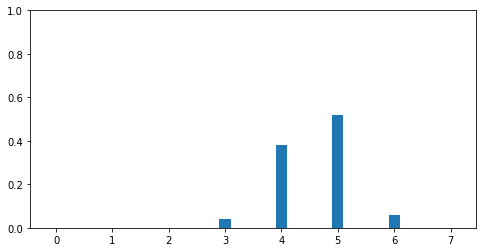

In [48]:
pos = np.array([0, 0, 0.4, 0.6, 0, 0, 0, 0])
res = predict(pos, 2, 0.8, 0.1, 0.1)
print(res)
# --
plt.figure(figsize=(8, 4))
plt.bar(x=range(pos.shape[0]), height=res, width=0.2)
plt.ylim((0, 1))
plt.show()

The consequence of a noisy sensor is that there is always a bit of information that is lost on every update. Performing an update an infinite number of times, the result would of course change a bit and the overall probabilities will now be distributed across the position array.

## Integrating Measurements and Movement Updates

The actual process for our system should be:

```
measure > update > measure > update > ...
```

The output of the measurement is fed into the update. The update step with a degraded certainty is now fed back into the measurement step. The first cycle degrades the knowledge we have of the measurement by a small amount. Now, taking another measurement, it now has the chance to conflict against the update step. This added bit of information now can make our beliefs more certain as it contains the actual true statement of the value being measured with some amount of uncertainty.

In [76]:
p = np.array([0.1] * 10)
p = update(p, 1, 0.6, 0.2)
p_1p = predict(p, 1, 0.8, 0.1, 0.1)
p_1m = update(p_1p, 1, 0.6, 0.2)

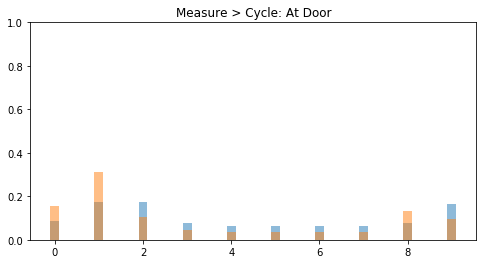

In [85]:
plt.figure(figsize=(8, 4))
plt.title("Measure > Cycle: At Door")
plt.bar(x=range(p.shape[0]), height=p_1p, width=0.2, alpha=0.5)
plt.bar(x=range(p.shape[0]), height=p_1m, width=0.2, alpha=0.5)
plt.ylim((0, 1))
plt.show()

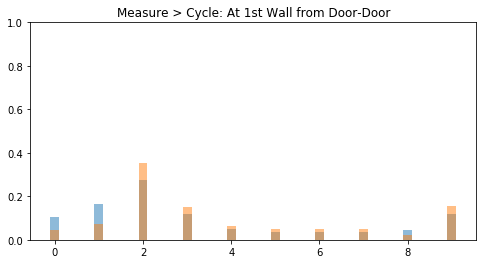

In [83]:
p_2p = predict(p_1m, 1, 0.8, 0.1, 0.1)
p_2m = update(p_2p, 0, 0.6, 0.2)
# --
plt.figure(figsize=(8, 4))
plt.title("Measure > Cycle: At 1st Wall from Door-Door")
plt.bar(x=range(p.shape[0]), height=p_2p, width=0.2, alpha=0.5)
plt.bar(x=range(p.shape[0]), height=p_2m, width=0.2, alpha=0.5)
plt.ylim((0, 1))
plt.show()

The above series of graphs show the positions at different points in the hallway. Let me break down the series of graphs:

1. **Measure**: At first we measure with some probability the position 'door' as sent by the sensor to us. This distributes the probabilities across the doors / walls. 
2. **Update**: The update now looks for the probability of a door with the known uncertainties for the move in the future. This predicts what is the probability that the move occurred in the future.
3. **Measure**: This updates the prediction and says whether the dog actually moved. By moving and giving a good value, the probability of the position increases. This increase settles the quality of the update value.
4. **Update**: The update now predicts the next value reducing the probability across the board but increasing the next chance of value.
5. **Measure**: The truth now increases the probability that the value is true and sets the correct probabilities for the series of values.

## Effect of Bad Sensor Data

The idea of a *filter* is to filter out bad data. The question is whether the above system does that. Let's change the layout of hte hallway to alternating doors and walls.

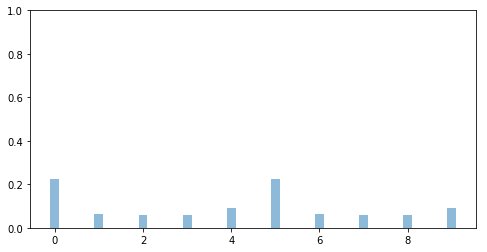

In [90]:
hallway = [1, 0, 1, 0, 0, 1, 0, 1, 0, 0]
pos = np.array([0.1] * 10)
# --
measurements = [1, 0, 1, 0, 0]
for m in measurements:
    pos = update(pos, m, 0.6, 0.2)
    pos = predict(pos, 1, 0.8, 0.1, 0.1)
# --
plt.figure(figsize=(8, 4))
plt.bar(x=range(p.shape[0]), height=pos, width=0.2, alpha=0.5)
plt.ylim((0, 1))
plt.show()

The above measurements, the initial positions can either be [0] or [5] due to the sequence of measurements we saw. By injecting a bad measurement, the overall knowledge is now completely eroded. However, the highest probabilities are still [0] / [5] but we have just become less certain of those positions. Now, correcting this by continuing the different series of measurements.

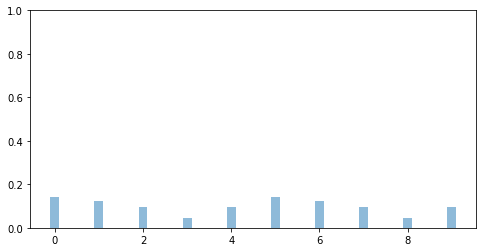

In [91]:
pos = update(pos, m, 0.6, 0.2)
pos = predict(pos, 1, 0.8, 0.1, 0.1)
# ==
plt.figure(figsize=(8, 4))
plt.bar(x=range(p.shape[0]), height=pos, width=0.2, alpha=0.5)
plt.ylim((0, 1))
plt.show()

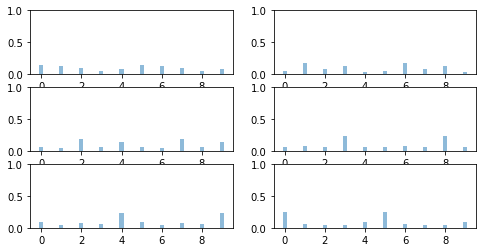

In [93]:
measurements = [0, 1, 0, 1, 0, 0]
plt.figure(figsize=(8, 4))
for i, m in enumerate(measurements):
    pos = update(pos, m, 0.6, 0.2)
    pos = predict(pos, 1, 0.8, 0.1, 0.1)
    plt.subplot(3, 2, i+1)
    plt.bar(x=range(p.shape[0]), height=pos, width=0.2, alpha=0.5)
    plt.ylim((0, 1))

## Drawbacks and Limitations

The above graph shows that we have quickly converged on the right value even though the results are not very fast. The above filter is called a `histogram filter` which works for multi-modal, discrete data. 

The limitations of this filter are:

1. Scaling: This filter does not scale well with many variables. In multi-dimensional use-cases, the histogram is replaced by a multidimensional grid to store the probabilities at each discrete location requiring updates on all points in the grid requiring exorbitant amounts of running time. 
2. Discreteness: The filter is discrete while most of the data we have are continuous. The histogram filter requires that the model of the output for the filter is a set of discrete points. The data gets worse quite soon as we increase the resolution of the bins.
3. Multimodal histograms: If the GPS reported that it is 40% sure that you are on street D and 30% sure on another street, the data is unuseful. There aren't clear mathematical way to extract error information from histograms. Heuristics show that there is not a clear determination.

The fundamental difficulty is that the filter does not represent accurately the world. There is a possibility that the dog exists in two places at the same time which can only be solved via heuristics. There is `Multi Hypothesis Tracking` (MHT) which tries to consolidate a story approach and backtracking to fix the older hypothesis. 